In [2]:
import sys
!{sys.executable} -m pip install pygam

# Data Handling
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling - GLM, GAM, RF
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from pygam import LinearGAM, s, f  # For Generalized Additive Models

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Optional - for hierarchical modeling if extended
# import pymc3 as pm  # Uncomment if you plan to use Bayesian hierarchical models

In [3]:
# Set base path
base_path = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/processed"

# File paths
ct_master_path = os.path.join(base_path, "ct_master.csv")
modality_counts_path = os.path.join(base_path, "modality_procedure_counts_by_age_band_2024.csv")
population_path = os.path.join(base_path, "south_west_population_2024.csv")

# Load CSVs
ct_master_df = pd.read_csv(ct_master_path)
modality_counts_df = pd.read_csv(modality_counts_path)
population_df = pd.read_csv(population_path)

# Display basic checks
print("CT Master Data - Columns:")
print(ct_master_df.columns.tolist())
print("\nHead:")
print(ct_master_df.head(), "\n")

print("Modality Procedure Counts by Age Band 2024 - Columns:")
print(modality_counts_df.columns.tolist())
print("\nHead:")
print(modality_counts_df.head(), "\n")

print("South West Population 2024 - Columns:")
print(population_df.columns.tolist())
print("\nHead:")
print(population_df.head())

CT Master Data - Columns:
['icb_code', 'icb_name', 'lsoa_code', 'nhs_region', 'site_code', 'site_name', 'provider_code', 'provider_name', 'activity_month', 'financial_year', 'financial_month', 'test_date', 'age', 'sex', 'modality', 'sub_modality', 'procedure_name', 'referral_type', 'patient_source', 'cancer_flag', 'subcancer_flag', 'referring_org_code', 'referring_org_name', 'age_band', 'age_mid', 'modality_clean', 'ps_bucket', 'is_ct', 'is_mri', 'is_endo']

Head:
  icb_code                icb_name  lsoa_code  \
0      11X  NHS SOMERSET ICB - 11X  E01029112   
1      11X  NHS SOMERSET ICB - 11X  E01029135   
2      11X  NHS SOMERSET ICB - 11X  E01029237   
3      11X  NHS SOMERSET ICB - 11X  E01029255   
4      11X  NHS SOMERSET ICB - 11X  E01029205   

                        nhs_region site_code                       site_name  \
0  Head structure (body structure)     RH5A8  MUSGROVE PARK HOSPITAL (RH5A8)   
1  Head structure (body structure)     RH5A8  MUSGROVE PARK HOSPITAL (RH5A8)

In [8]:
# ----------------------------------------------
# CLASSIFY PATIENT SOURCE: Emergency / Elective
# ----------------------------------------------
def classify_source(ps):
    if ps in [
        "Accident and Emergency Department (this Health Care Provider)",
        "Admitted Patient Care - Inpatient (this Health Care Provider)"
    ]:
        return "Emergency"
    elif ps in [
        "Outpatient (this Health Care Provider)",
        "GP Direct Access",
        "Admitted Patient Care - Day case (this Health Care Provider)"
    ]:
        return "Elective"
    else:
        return "Other"

ct_master_df['source_group'] = ct_master_df['patient_source'].map(classify_source)

# Add exam_count column to support aggregation
if 'exam_count' not in ct_master_df.columns:
    ct_master_df['exam_count'] = 1

# ----------------------------------------------
# SPLIT INTO TOTAL, EMERGENCY, ELECTIVE
# ----------------------------------------------
df_total = ct_master_df.copy()
df_emergency = ct_master_df[ct_master_df['source_group'] == "Emergency"].copy()
df_elective = ct_master_df[ct_master_df['source_group'] == "Elective"].copy()


In [11]:
# ------------------------------------------------------------
# STEP 0: Ensure exam_count column exists (row = 1 exam)
# ------------------------------------------------------------
if 'exam_count' not in ct_master_df.columns:
    ct_master_df['exam_count'] = 1

# ------------------------------------------------------------
# STEP 1: Define age band order for sorting
# ------------------------------------------------------------
age_band_order = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39",
    "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74",
    "75-79", "80-84", "85+"
]

# ------------------------------------------------------------
# STEP 2: Define function for summarising demand
# ------------------------------------------------------------
def summarise_demand(df, label):
    summary = (
        df.groupby("age_band")["exam_count"]
        .sum()
        .reset_index()
        .rename(columns={"exam_count": label})
    )
    return summary

# ------------------------------------------------------------
# STEP 3: Summarise total, emergency, elective by age_band
# ------------------------------------------------------------
summary_total = summarise_demand(df_total, "CT_Total")
summary_emergency = summarise_demand(df_emergency, "CT_Emergency")
summary_elective = summarise_demand(df_elective, "CT_Elective")

# ------------------------------------------------------------
# STEP 4: Merge summaries with population data
# ------------------------------------------------------------
ct_naive_df = (
    summary_total
    .merge(summary_emergency, on="age_band", how="left")
    .merge(summary_elective, on="age_band", how="left")
    .merge(age_band_population, on="age_band", how="left")
)

# Fill missing values with 0
ct_naive_df[['CT_Emergency', 'CT_Elective']] = ct_naive_df[['CT_Emergency', 'CT_Elective']].fillna(0)

# ------------------------------------------------------------
# STEP 5: Calculate rates per 1k and per 10k
# ------------------------------------------------------------
for col in ['CT_Total', 'CT_Emergency', 'CT_Elective']:
    ct_naive_df[f'{col.lower()}_per_10k'] = (
        ct_naive_df[col] / ct_naive_df['population_2024']
    ) * 10000

    ct_naive_df[f'{col.lower()}_per_1k'] = (
        ct_naive_df[col] / ct_naive_df['population_2024']
    ) * 1000

# Round for clarity
rate_cols = [col for col in ct_naive_df.columns if '_per_' in col]
ct_naive_df[rate_cols] = ct_naive_df[rate_cols].round(2)

# ------------------------------------------------------------
# STEP 6: Sort by correct age_band order
# ------------------------------------------------------------
ct_naive_df['age_band'] = pd.Categorical(
    ct_naive_df['age_band'],
    categories=age_band_order,
    ordered=True
)
ct_naive_df = ct_naive_df.sort_values('age_band').reset_index(drop=True)

# ------------------------------------------------------------
# STEP 7: Display final output
# ------------------------------------------------------------
display_cols = [
    'age_band', 'population_2024',
    'CT_Total', 'ct_total_per_1k',
    'CT_Emergency', 'ct_emergency_per_1k',
    'CT_Elective', 'ct_elective_per_1k'
]
print(ct_naive_df[display_cols])


   age_band  population_2024  CT_Total  ct_total_per_1k  CT_Emergency  \
0       0-4           283792      1488             5.24          1203   
1       5-9           322018      1471             4.57          1042   
2     10-14           331416      2965             8.95          1933   
3     15-19           324765      7712            23.75          5729   
4     20-24           342425     10019            29.26          7218   
5     25-29           342688     12889            37.61          8811   
6     30-34           367510     17076            46.46         10935   
7     35-39           355513     19939            56.09         11903   
8     40-44           341210     23414            68.62         12835   
9     45-49           362553     26402            72.82         13375   
10    50-54           413048     39307            95.16         17921   
11    55-59           423510     54116           127.78         22050   
12    60-64           376552     62181           16

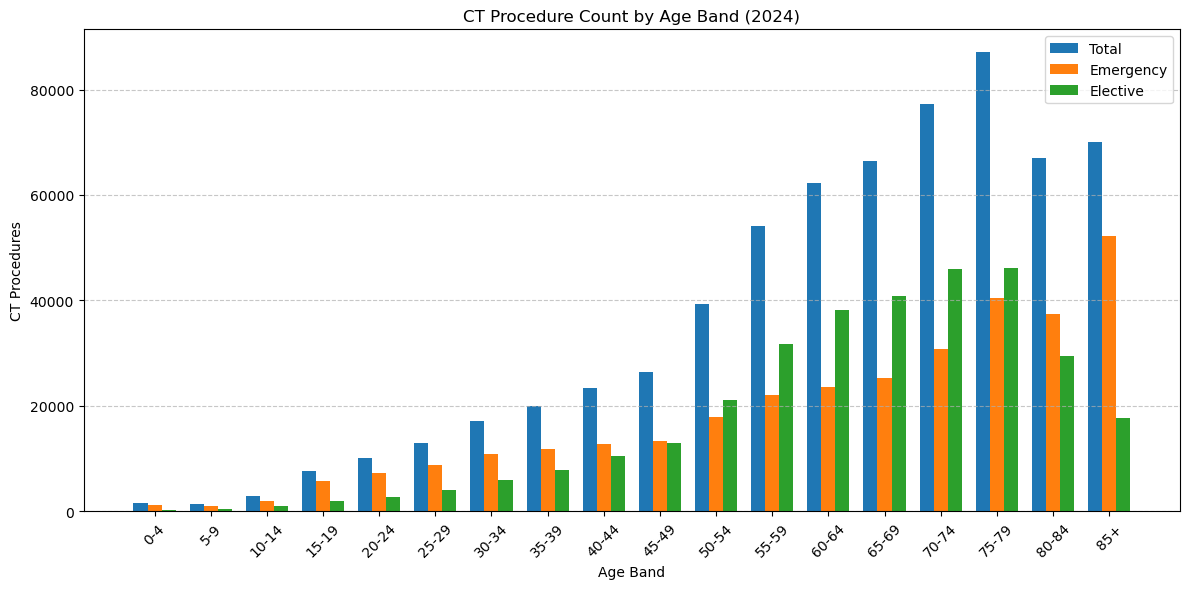

In [12]:
plt.figure(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(ct_naive_df['age_band']))

plt.bar(x - bar_width, ct_naive_df['CT_Total'], width=bar_width, label='Total')
plt.bar(x, ct_naive_df['CT_Emergency'], width=bar_width, label='Emergency')
plt.bar(x + bar_width, ct_naive_df['CT_Elective'], width=bar_width, label='Elective')

plt.xlabel('Age Band')
plt.ylabel('CT Procedures')
plt.title('CT Procedure Count by Age Band (2024)')
plt.xticks(x, ct_naive_df['age_band'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


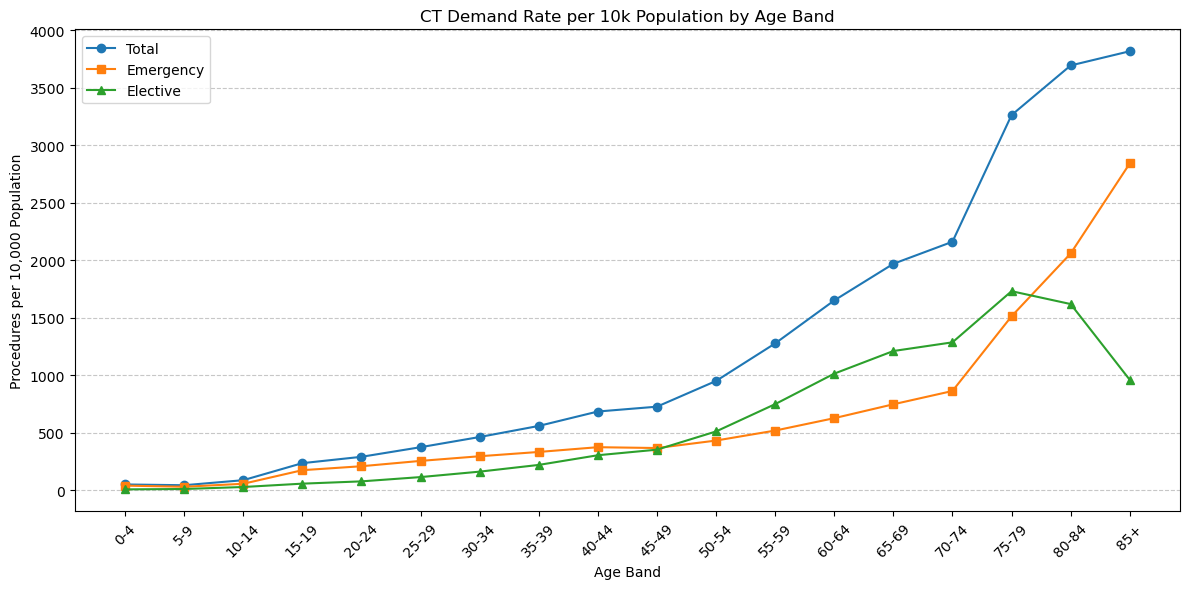

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(ct_naive_df['age_band'], ct_naive_df['ct_total_per_10k'], label='Total', marker='o')
plt.plot(ct_naive_df['age_band'], ct_naive_df['ct_emergency_per_10k'], label='Emergency', marker='s')
plt.plot(ct_naive_df['age_band'], ct_naive_df['ct_elective_per_10k'], label='Elective', marker='^')

plt.xlabel('Age Band')
plt.ylabel('Procedures per 10,000 Population')
plt.title('CT Demand Rate per 10k Population by Age Band')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Step 1: Calculate demand volume (count = rate_per_1k × pop / 1000)
ct_naive_df['demand_total'] = (ct_naive_df['ct_total_per_1k'] * ct_naive_df['population_2024']) / 1000
ct_naive_df['demand_emergency'] = (ct_naive_df['ct_emergency_per_1k'] * ct_naive_df['population_2024']) / 1000
ct_naive_df['demand_elective'] = (ct_naive_df['ct_elective_per_1k'] * ct_naive_df['population_2024']) / 1000

# Step 2: Normalise to PDF
total_sum = ct_naive_df['demand_total'].sum()
em_sum = ct_naive_df['demand_emergency'].sum()
el_sum = ct_naive_df['demand_elective'].sum()

ct_naive_df['pdf_total'] = ct_naive_df['demand_total'] / total_sum
ct_naive_df['pdf_emergency'] = ct_naive_df['demand_emergency'] / em_sum
ct_naive_df['pdf_elective'] = ct_naive_df['demand_elective'] / el_sum

# Step 3: Confirm normalisation
print(f"PDF sums: total={ct_naive_df['pdf_total'].sum():.6f}, "
      f"emergency={ct_naive_df['pdf_emergency'].sum():.6f}, "
      f"elective={ct_naive_df['pdf_elective'].sum():.6f}")


PDF sums: total=1.000000, emergency=1.000000, elective=1.000000


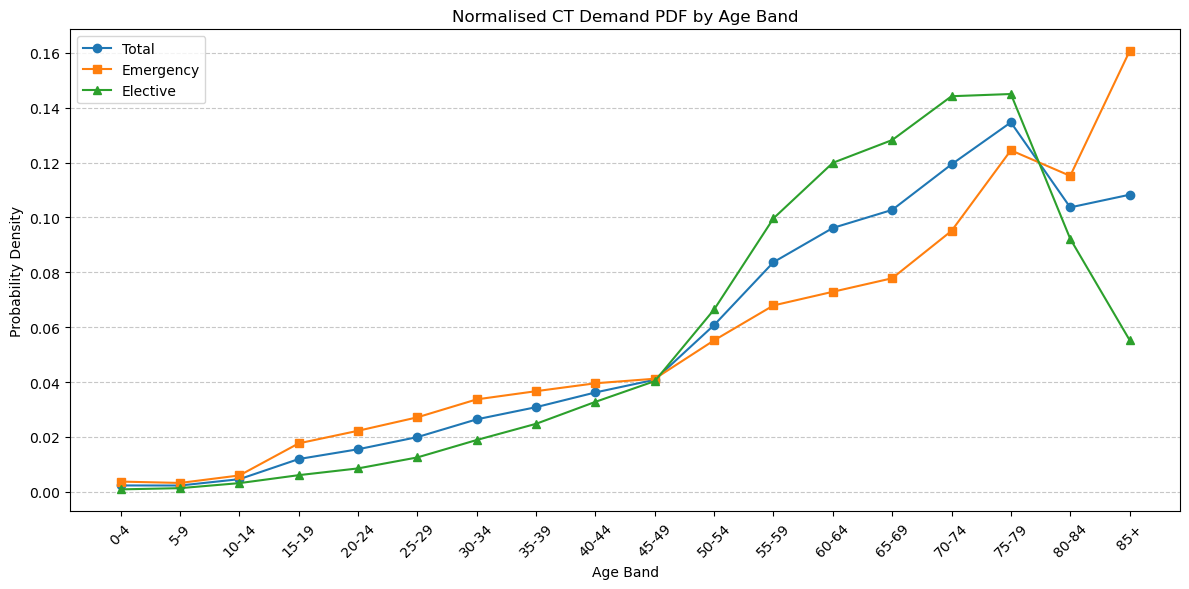

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(ct_naive_df['age_band'], ct_naive_df['pdf_total'], label='Total', marker='o')
plt.plot(ct_naive_df['age_band'], ct_naive_df['pdf_emergency'], label='Emergency', marker='s')
plt.plot(ct_naive_df['age_band'], ct_naive_df['pdf_elective'], label='Elective', marker='^')

plt.xlabel('Age Band')
plt.ylabel('Probability Density')
plt.title('Normalised CT Demand PDF by Age Band')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# ------------------------------------------------------------
# Naïve Model (Continuous Age) for CT: Total, Emergency, Elective
# ------------------------------------------------------------

# Step 1: Filter CT records
ct_df_cont = ct_master_df[ct_master_df['is_ct'] == 1].copy()

# Step 2: Ensure source_group column is available
def classify_source(ps):
    if ps in [
        "Accident and Emergency Department (this Health Care Provider)",
        "Admitted Patient Care - Inpatient (this Health Care Provider)"
    ]:
        return "Emergency"
    elif ps in [
        "Outpatient (this Health Care Provider)",
        "GP Direct Access",
        "Admitted Patient Care - Day case (this Health Care Provider)"
    ]:
        return "Elective"
    else:
        return "Other"

if 'source_group' not in ct_df_cont.columns:
    ct_df_cont['source_group'] = ct_df_cont['patient_source'].map(classify_source)

# Step 3: Add exam_count = 1 if not present
if 'exam_count' not in ct_df_cont.columns:
    ct_df_cont['exam_count'] = 1

# Step 4: Aggregate CTs by age and source_group
ct_by_age_source = (
    ct_df_cont.groupby(['age', 'source_group'])['exam_count']
    .sum()
    .reset_index()
    .pivot(index='age', columns='source_group', values='exam_count')
    .fillna(0)
    .reset_index()
    .rename(columns={
        'Emergency': 'CT_Emergency',
        'Elective': 'CT_Elective'
    })
)

# Step 5: Add CT_Total column
ct_by_age_source['CT_Total'] = (
    ct_by_age_source['CT_Emergency'] + ct_by_age_source['CT_Elective']
)

# Step 6: Load population data
population_df = pd.read_csv(population_path)
population_df.rename(columns={'population': 'population_2024'}, inplace=True)

# Step 7: Merge with population
merged_df = ct_by_age_source.merge(population_df, on='age', how='left')

# Step 8: Calculate demand per 1k and per 10k for each type
for col in ['CT_Total', 'CT_Emergency', 'CT_Elective']:
    merged_df[f'{col.lower()}_per_10k'] = (merged_df[col] / merged_df['population_2024']) * 10000
    merged_df[f'{col.lower()}_per_1k'] = (merged_df[col] / merged_df['population_2024']) * 1000

# ------------------------------------------------------------
# Step 8b: Calculate proportion of Emergency and Elective of Total (per age)
# ------------------------------------------------------------
# Avoid division-by-zero where CT_Total is 0
merged_df['pct_emergency_of_total'] = np.where(
    merged_df['CT_Total'] > 0,
    (merged_df['CT_Emergency'] / merged_df['CT_Total']) * 100,
    0
)

merged_df['pct_elective_of_total'] = np.where(
    merged_df['CT_Total'] > 0,
    (merged_df['CT_Elective'] / merged_df['CT_Total']) * 100,
    0
)

# Round for readability
merged_df[['pct_emergency_of_total', 'pct_elective_of_total']] = \
    merged_df[['pct_emergency_of_total', 'pct_elective_of_total']].round(1)



# Step 9: Round for display
rate_cols = [col for col in merged_df.columns if '_per_' in col]
merged_df[rate_cols] = merged_df[rate_cols].round(2)

# Step 10: Sort by age
merged_df = merged_df.sort_values('age').reset_index(drop=True)

# Display sample
print(merged_df[['age', 'population_2024', 'CT_Total', 'ct_total_per_1k',
                 'CT_Emergency', 'ct_emergency_per_1k',
                 'CT_Elective', 'ct_elective_per_1k']].head())


   age  population_2024  CT_Total  ct_total_per_1k  CT_Emergency  \
0  0.0          52166.0     770.0            14.76         655.0   
1  1.0          54517.0     376.0             6.90         304.0   
2  2.0          56664.0     243.0             4.29         204.0   
3  3.0          57911.0     328.0             5.66         281.0   
4  4.0          59455.0     299.0             5.03         235.0   

   ct_emergency_per_1k  CT_Elective  ct_elective_per_1k  
0                12.56        115.0                2.20  
1                 5.58         72.0                1.32  
2                 3.60         39.0                0.69  
3                 4.85         47.0                0.81  
4                 3.95         64.0                1.08  


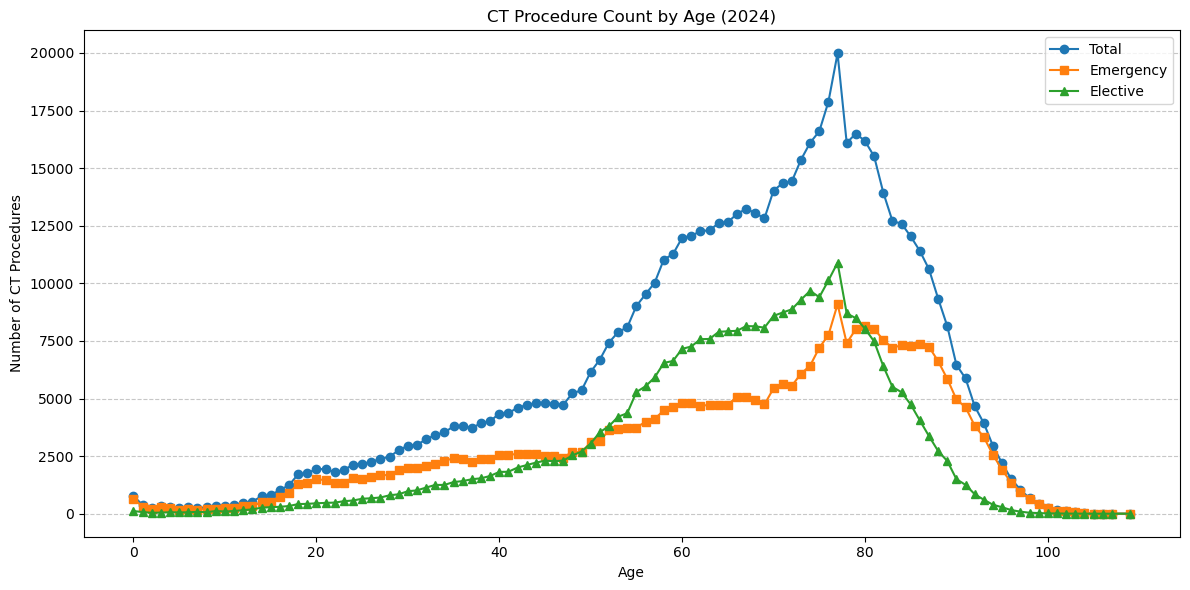

In [17]:
plt.figure(figsize=(12, 6))

plt.plot(merged_df['age'], merged_df['CT_Total'], label='Total', marker='o')
plt.plot(merged_df['age'], merged_df['CT_Emergency'], label='Emergency', marker='s')
plt.plot(merged_df['age'], merged_df['CT_Elective'], label='Elective', marker='^')

plt.xlabel('Age')
plt.ylabel('Number of CT Procedures')
plt.title('CT Procedure Count by Age (2024)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


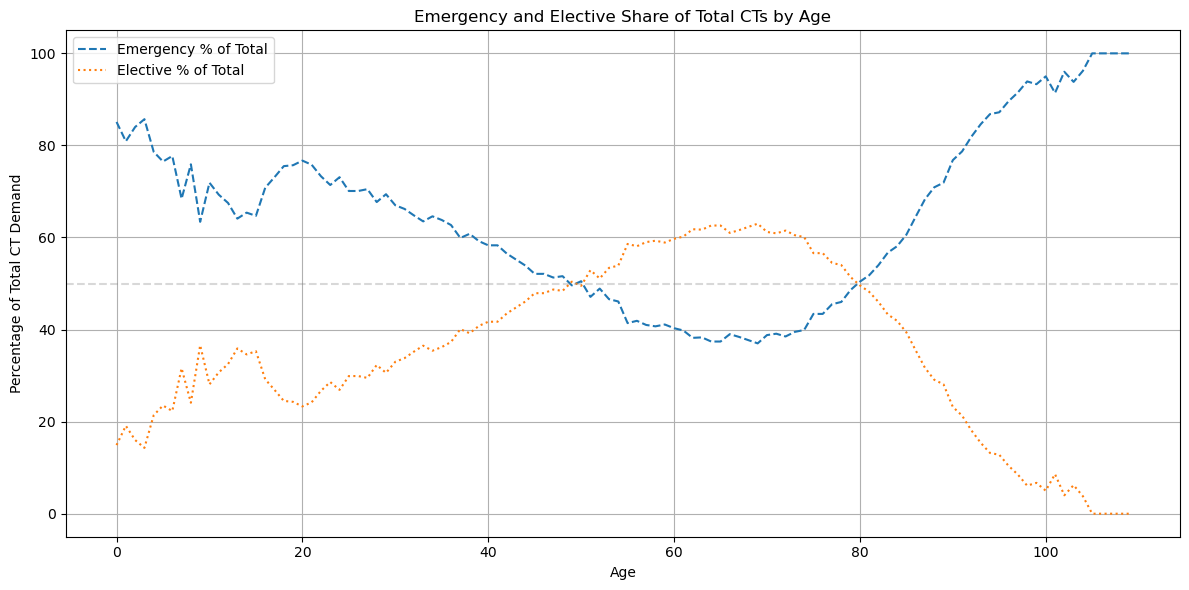

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['age'], merged_df['pct_emergency_of_total'], label='Emergency % of Total', linestyle='--')
plt.plot(merged_df['age'], merged_df['pct_elective_of_total'], label='Elective % of Total', linestyle=':')
plt.axhline(50, color='grey', linestyle='--', alpha=0.3)
plt.xlabel('Age')
plt.ylabel('Percentage of Total CT Demand')
plt.title('Emergency and Elective Share of Total CTs by Age')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


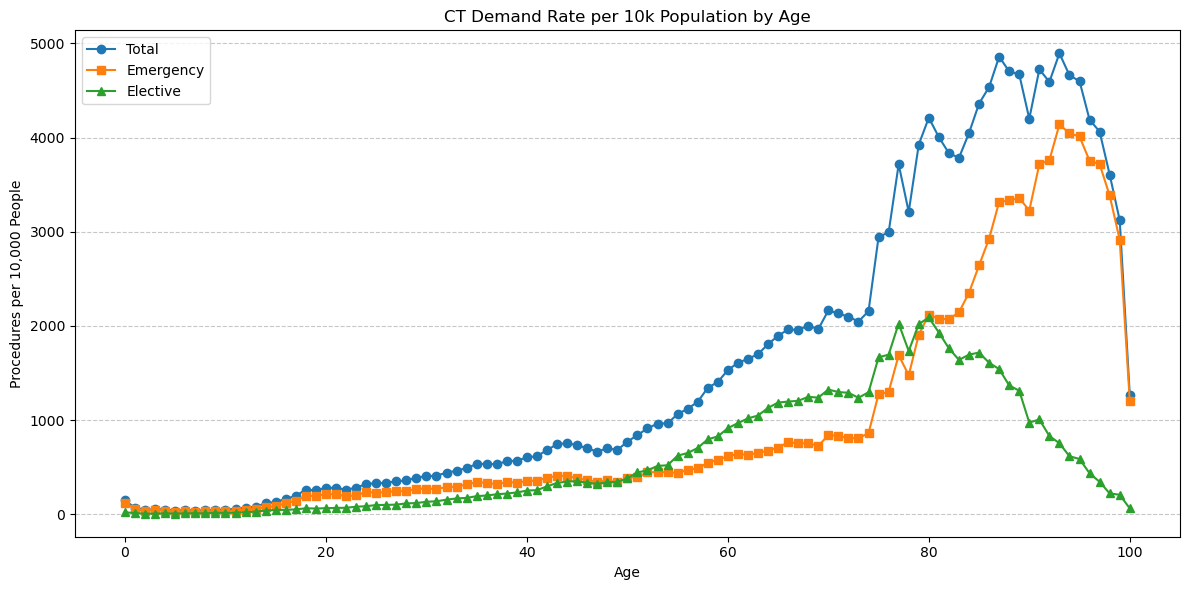

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(merged_df['age'], merged_df['ct_total_per_10k'], label='Total', marker='o')
plt.plot(merged_df['age'], merged_df['ct_emergency_per_10k'], label='Emergency', marker='s')
plt.plot(merged_df['age'], merged_df['ct_elective_per_10k'], label='Elective', marker='^')

plt.xlabel('Age')
plt.ylabel('Procedures per 10,000 People')
plt.title('CT Demand Rate per 10k Population by Age')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


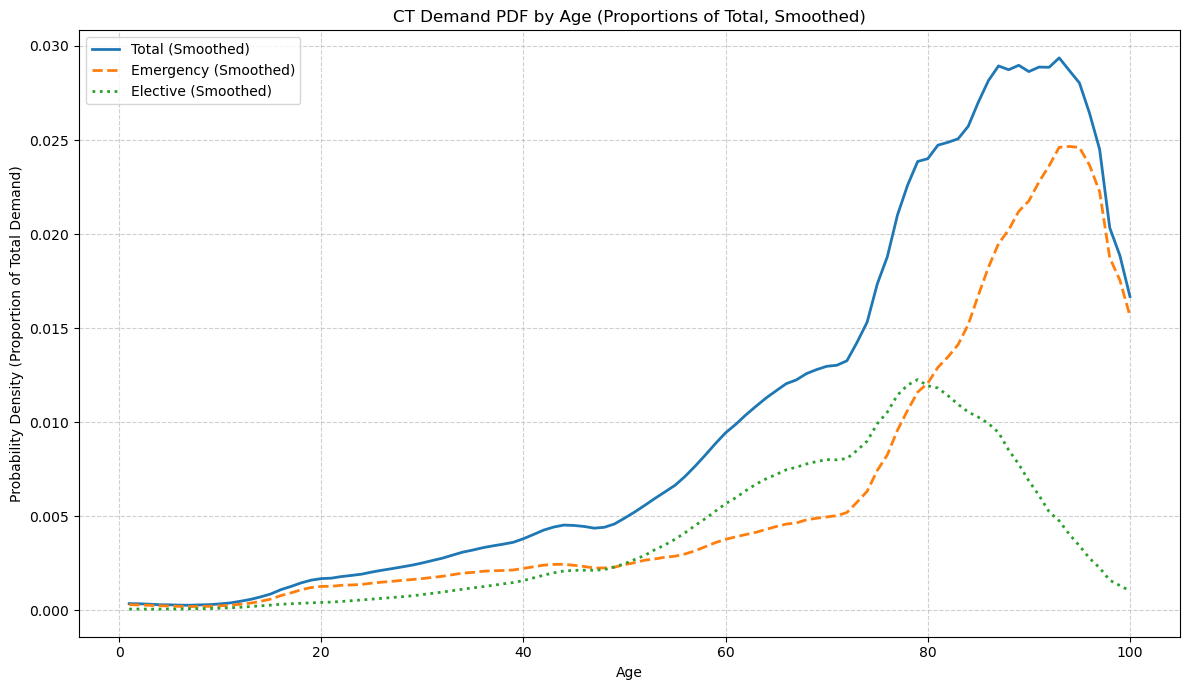

In [20]:
# ------------------------------------------------------------
# Prepare full age range and merge with raw demand
# ------------------------------------------------------------
full_age_range = pd.DataFrame({'age': np.arange(1, 101)})

# Merge total, emergency, elective per 1k
cols_to_merge = [
    'age',
    'ct_total_per_1k',
    'ct_emergency_per_1k',
    'ct_elective_per_1k'
]
merged_all = full_age_range.merge(merged_df[cols_to_merge], on='age', how='left').fillna(0)

# ------------------------------------------------------------
# Calculate shared total demand across all age groups
# ------------------------------------------------------------
# Convert rates to estimated counts per age
merged_all['total_demand'] = merged_all['ct_total_per_1k']
merged_all['emergency_demand'] = merged_all['ct_emergency_per_1k']
merged_all['elective_demand'] = merged_all['ct_elective_per_1k']

# Global denominator = total demand over all ages
total_demand_sum = merged_all['total_demand'].sum()

# ------------------------------------------------------------
# Normalise to shared total demand PDF
# ------------------------------------------------------------
merged_all['pdf_total'] = merged_all['total_demand'] / total_demand_sum
merged_all['pdf_emergency'] = merged_all['emergency_demand'] / total_demand_sum
merged_all['pdf_elective'] = merged_all['elective_demand'] / total_demand_sum

# ------------------------------------------------------------
# Apply moving average smoothing
# ------------------------------------------------------------
window = 5
for col in ['pdf_total', 'pdf_emergency', 'pdf_elective']:
    merged_all[f'{col}_smoothed'] = merged_all[col].rolling(window=window, center=True, min_periods=1).mean()

# ------------------------------------------------------------
# Plot smoothed PDFs (proportions of shared total)
# ------------------------------------------------------------
plt.figure(figsize=(12, 7))
plt.plot(merged_all['age'], merged_all['pdf_total_smoothed'], label='Total (Smoothed)', linewidth=2)
plt.plot(merged_all['age'], merged_all['pdf_emergency_smoothed'], label='Emergency (Smoothed)', linestyle='--', linewidth=2)
plt.plot(merged_all['age'], merged_all['pdf_elective_smoothed'], label='Elective (Smoothed)', linestyle=':', linewidth=2)

plt.xlabel('Age')
plt.ylabel('Probability Density (Proportion of Total Demand)')
plt.title('CT Demand PDF by Age (Proportions of Total, Smoothed)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [21]:
# ------------------------------------------------------------
# Step: Calculate % of Total, Emergency, Elective CTs by Age Range
# ------------------------------------------------------------

# Total demand sums
total_ct = merged_df['CT_Total'].sum()
emergency_ct = merged_df['CT_Emergency'].sum()
elective_ct = merged_df['CT_Elective'].sum()

# Define age band ranges
age_band_ranges = [
    (0, 49),
    (50, 100),
    (60, 100),
    (70, 100),
    (80, 100),
    (90, 100)
]

# Header
print("Percentage of CT Procedures by Age Band:\n")
print(f"{'Age Band':<12} {'Total %':>10} {'Emergency %':>15} {'Elective %':>15}")
print("-" * 54)

# Loop through each age band and compute percentages
for start_age, end_age in age_band_ranges:
    df_band = merged_df[merged_df['age'].between(start_age, end_age)]
    
    band_total = df_band['CT_Total'].sum()
    band_em = df_band['CT_Emergency'].sum()
    band_el = df_band['CT_Elective'].sum()
    
    pct_total = (band_total / total_ct) * 100
    pct_em = (band_em / emergency_ct) * 100 if emergency_ct > 0 else 0
    pct_el = (band_el / elective_ct) * 100 if elective_ct > 0 else 0
    
    print(f"{start_age}–{end_age:<7} {pct_total:10.2f}% {pct_em:15.2f}% {pct_el:15.2f}%")


Percentage of CT Procedures by Age Band:

Age Band        Total %     Emergency %      Elective %
------------------------------------------------------
0–49           18.18%           22.30%           13.99%
50–100          81.76%           77.60%           86.00%
60–100          68.24%           65.84%           70.69%
70–100          48.69%           51.00%           46.33%
80–100          23.65%           29.92%           17.26%
90–100           4.64%            7.60%            1.63%


Emergency GLM (Smoothed)       | MAE: 22.24 | RMSE: 42.11 | R²: 0.872
Emergency RF (Smoothed)        | MAE: 5.33 | RMSE: 16.58 | R²: 0.980
Emergency Ensemble (Smoothed)  | MAE: 14.44 | RMSE: 30.49 | R²: 0.933


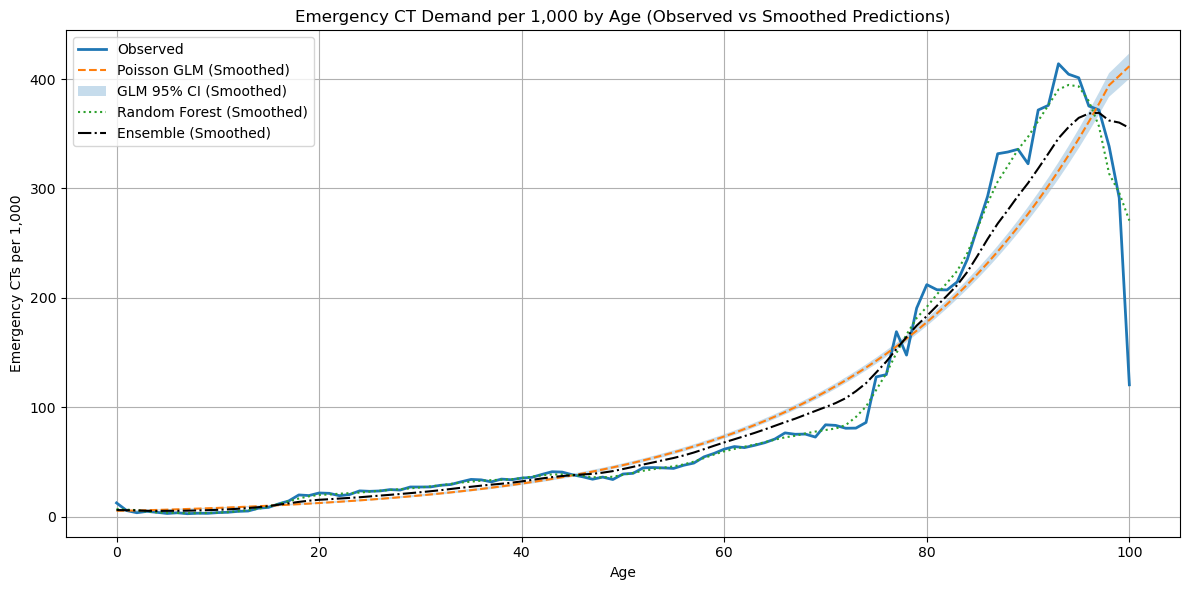

In [26]:
# ------------------------------------------------------------
# Evaluation Function for Model Accuracy
# ------------------------------------------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(true, pred, name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"{name:<30} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")


# ----------------------------
# Emergency Demand Forecasting
# ----------------------------
model_df_em = merged_df.copy()
model_df_em.dropna(subset=["ct_emergency_per_1k"], inplace=True)

# Poisson GLM
glm_em = smf.glm("ct_emergency_per_1k ~ age", data=model_df_em, family=sm.families.Poisson()).fit()
model_df_em["predicted_glm"] = glm_em.predict(model_df_em)
ci_em = glm_em.get_prediction(model_df_em).summary_frame()
model_df_em["glm_ci_lower"] = ci_em["mean_ci_lower"]
model_df_em["glm_ci_upper"] = ci_em["mean_ci_upper"]

# Random Forest
rf_em = RandomForestRegressor(n_estimators=100, random_state=42)
rf_em.fit(model_df_em[["age"]], model_df_em["ct_emergency_per_1k"])
model_df_em["predicted_rf"] = rf_em.predict(model_df_em[["age"]])

# Ensemble
model_df_em["predicted_ensemble"] = 0.6 * model_df_em["predicted_glm"] + 0.4 * model_df_em["predicted_rf"]

# Smoothing
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df_em[f"{col}_smoothed"] = model_df_em[col].rolling(window=5, center=True, min_periods=1).mean()

model_df_em["glm_ci_lower_smoothed"] = model_df_em["glm_ci_lower"].rolling(5, center=True, min_periods=1).mean()
model_df_em["glm_ci_upper_smoothed"] = model_df_em["glm_ci_upper"].rolling(5, center=True, min_periods=1).mean()

# Evaluation
evaluate(model_df_em["ct_emergency_per_1k"], model_df_em["predicted_glm_smoothed"], "Emergency GLM (Smoothed)")
evaluate(model_df_em["ct_emergency_per_1k"], model_df_em["predicted_rf_smoothed"],  "Emergency RF (Smoothed)")
evaluate(model_df_em["ct_emergency_per_1k"], model_df_em["predicted_ensemble_smoothed"], "Emergency Ensemble (Smoothed)")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df_em, x="age", y="ct_emergency_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df_em, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.fill_between(model_df_em["age"], model_df_em["glm_ci_lower_smoothed"], model_df_em["glm_ci_upper_smoothed"],
                 alpha=0.25, label="GLM 95% CI (Smoothed)")
sns.lineplot(data=model_df_em, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")
sns.lineplot(data=model_df_em, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")
plt.title("Emergency CT Demand per 1,000 by Age (Observed vs Smoothed Predictions)")
plt.ylabel("Emergency CTs per 1,000")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Elective GLM (Smoothed)        | MAE: 33.34 | RMSE: 50.05 | R²: 0.329
Elective RF (Smoothed)         | MAE: 2.63 | RMSE: 5.00 | R²: 0.993
Elective Ensemble (Smoothed)   | MAE: 20.32 | RMSE: 30.92 | R²: 0.744


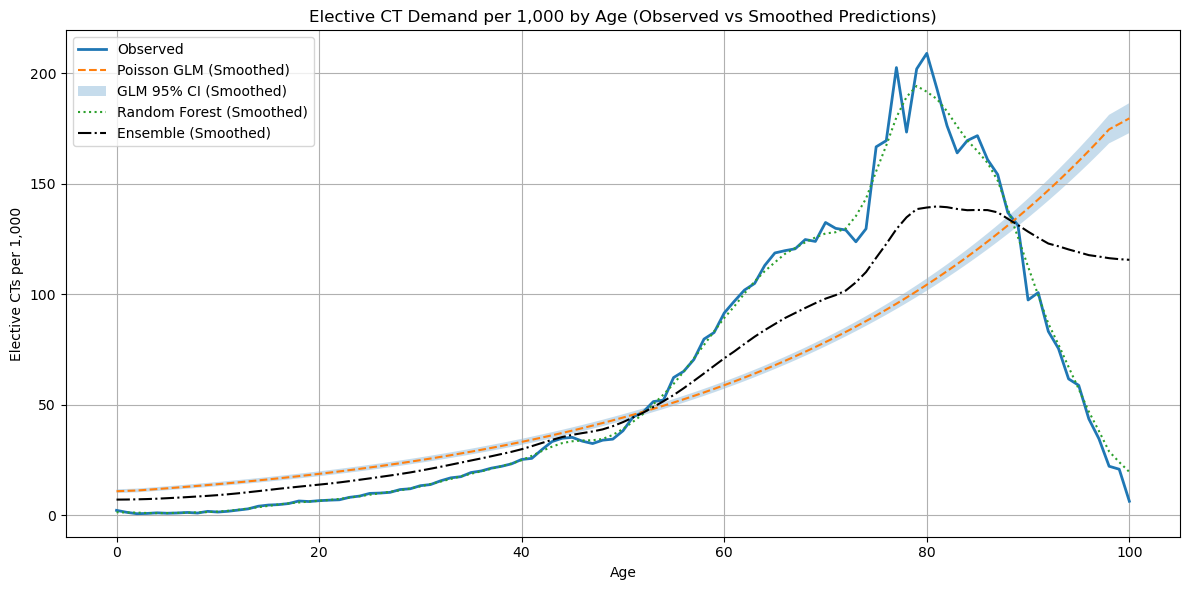

In [27]:
# ----------------------------
# Elective Demand Forecasting
# ----------------------------
model_df_el = merged_df.copy()
model_df_el.dropna(subset=["ct_elective_per_1k"], inplace=True)

# Poisson GLM
glm_el = smf.glm("ct_elective_per_1k ~ age", data=model_df_el, family=sm.families.Poisson()).fit()
model_df_el["predicted_glm"] = glm_el.predict(model_df_el)
ci_el = glm_el.get_prediction(model_df_el).summary_frame()
model_df_el["glm_ci_lower"] = ci_el["mean_ci_lower"]
model_df_el["glm_ci_upper"] = ci_el["mean_ci_upper"]

# Random Forest
rf_el = RandomForestRegressor(n_estimators=100, random_state=42)
rf_el.fit(model_df_el[["age"]], model_df_el["ct_elective_per_1k"])
model_df_el["predicted_rf"] = rf_el.predict(model_df_el[["age"]])

# Ensemble
model_df_el["predicted_ensemble"] = 0.6 * model_df_el["predicted_glm"] + 0.4 * model_df_el["predicted_rf"]

# Smoothing
for col in ["predicted_glm", "predicted_rf", "predicted_ensemble"]:
    model_df_el[f"{col}_smoothed"] = model_df_el[col].rolling(window=5, center=True, min_periods=1).mean()

model_df_el["glm_ci_lower_smoothed"] = model_df_el["glm_ci_lower"].rolling(5, center=True, min_periods=1).mean()
model_df_el["glm_ci_upper_smoothed"] = model_df_el["glm_ci_upper"].rolling(5, center=True, min_periods=1).mean()

# Evaluation
evaluate(model_df_el["ct_elective_per_1k"], model_df_el["predicted_glm_smoothed"], "Elective GLM (Smoothed)")
evaluate(model_df_el["ct_elective_per_1k"], model_df_el["predicted_rf_smoothed"],  "Elective RF (Smoothed)")
evaluate(model_df_el["ct_elective_per_1k"], model_df_el["predicted_ensemble_smoothed"], "Elective Ensemble (Smoothed)")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=model_df_el, x="age", y="ct_elective_per_1k", label="Observed", linewidth=2)
sns.lineplot(data=model_df_el, x="age", y="predicted_glm_smoothed", label="Poisson GLM (Smoothed)", linestyle="--")
plt.fill_between(model_df_el["age"], model_df_el["glm_ci_lower_smoothed"], model_df_el["glm_ci_upper_smoothed"],
                 alpha=0.25, label="GLM 95% CI (Smoothed)")
sns.lineplot(data=model_df_el, x="age", y="predicted_rf_smoothed", label="Random Forest (Smoothed)", linestyle=":")
sns.lineplot(data=model_df_el, x="age", y="predicted_ensemble_smoothed", label="Ensemble (Smoothed)", linestyle="-.", color="black")
plt.title("Elective CT Demand per 1,000 by Age (Observed vs Smoothed Predictions)")
plt.ylabel("Elective CTs per 1,000")
plt.xlabel("Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# Prepare data
model_df_em = merged_df.copy()
model_df_em.dropna(subset=["ct_emergency_per_1k"], inplace=True)

# Fit Poisson GLM
glm_em = smf.glm(
    formula="ct_emergency_per_1k ~ age",
    data=model_df_em,
    family=sm.families.Poisson()
).fit()

# Output summary
print("----- Emergency CT Poisson GLM Summary -----")
print(glm_em.summary())

----- Emergency CT Poisson GLM Summary -----
                  Generalized Linear Model Regression Results                  
Dep. Variable:     ct_emergency_per_1k   No. Observations:                  101
Model:                             GLM   Df Residuals:                       99
Model Family:                  Poisson   Df Model:                            1
Link Function:                     Log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -707.42
Date:                 Fri, 04 Jul 2025   Deviance:                       844.14
Time:                         10:24:33   Pearson chi2:                     759.
No. Iterations:                      6   Pseudo R-squ. (CS):              1.000
Covariance Type:             nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [29]:
# Prepare data
model_df_el = merged_df.copy()
model_df_el.dropna(subset=["ct_elective_per_1k"], inplace=True)

# Fit Poisson GLM
glm_el = smf.glm(
    formula="ct_elective_per_1k ~ age",
    data=model_df_el,
    family=sm.families.Poisson()
).fit()

# Output summary
print("----- Elective CT Poisson GLM Summary -----")
print(glm_el.summary())

----- Elective CT Poisson GLM Summary -----
                 Generalized Linear Model Regression Results                  
Dep. Variable:     ct_elective_per_1k   No. Observations:                  101
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1609.7
Date:                Fri, 04 Jul 2025   Deviance:                       2701.5
Time:                        10:24:40   Pearson chi2:                 2.33e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

In [31]:
# -----------------------------------------------
# Step 1: Load population data (continuous)
# -----------------------------------------------
population_df = pd.read_csv(population_path)
population_df.rename(columns={"population": "population_2024"}, inplace=True)

# -----------------------------------------------
# Step 2: Prepare CT dataset with patient_source & cancer_flag
# -----------------------------------------------
ct_df_cont = ct_master_df[ct_master_df["is_ct"] == 1].copy()
ct_df_cont.dropna(subset=["age", "cancer_flag", "patient_source"], inplace=True)

# Age and flag types
ct_df_cont["age"] = ct_df_cont["age"].astype(int)
ct_df_cont["cancer_flag"] = ct_df_cont["cancer_flag"].astype(str)
ct_df_cont["patient_source"] = ct_df_cont["patient_source"].astype("category")

# -----------------------------------------------
# Step 3: Classify patient source as Emergency / Elective
# -----------------------------------------------
def classify_source(ps):
    if ps in [
        "Accident and Emergency Department (this Health Care Provider)",
        "Admitted Patient Care - Inpatient (this Health Care Provider)"
    ]:
        return "Emergency"
    elif ps in [
        "Outpatient (this Health Care Provider)",
        "GP Direct Access",
        "Admitted Patient Care - Day case (this Health Care Provider)"
    ]:
        return "Elective"
    else:
        return "Other"

ct_df_cont["source_group"] = ct_df_cont["patient_source"].map(classify_source)

# -----------------------------------------------
# Step 4: Count CTs per (age, cancer_flag, source_group)
# -----------------------------------------------
grouped_df = (
    ct_df_cont.groupby(["age", "cancer_flag", "source_group"])
    .size()
    .reset_index(name="CT_Count")
)

# -----------------------------------------------
# Step 5: Merge with age-specific population
# -----------------------------------------------
grouped_df = grouped_df.merge(population_df, on="age", how="left")
grouped_df.dropna(subset=["population_2024"], inplace=True)

# Calculate rate per 1,000
grouped_df["ct_demand_per_1k"] = (grouped_df["CT_Count"] / grouped_df["population_2024"]) * 1000

# -----------------------------------------------
# Step 6: Emergency GLM
# -----------------------------------------------
grouped_em = grouped_df[grouped_df["source_group"] == "Emergency"].copy()

glm_formula_em = "ct_demand_per_1k ~ age + C(cancer_flag)"
glm_em = smf.glm(
    formula=glm_formula_em,
    data=grouped_em,
    family=sm.families.Poisson()
).fit()

print("-------- Emergency CT Poisson GLM --------")
print(glm_em.summary())

# -----------------------------------------------
# Step 7: Elective GLM
# -----------------------------------------------
grouped_el = grouped_df[grouped_df["source_group"] == "Elective"].copy()

glm_formula_el = "ct_demand_per_1k ~ age + C(cancer_flag)"
glm_el = smf.glm(
    formula=glm_formula_el,
    data=grouped_el,
    family=sm.families.Poisson()
).fit()

print("-------- Elective CT Poisson GLM --------")
print(glm_el.summary())


-------- Emergency CT Poisson GLM --------
                 Generalized Linear Model Regression Results                  
Dep. Variable:       ct_demand_per_1k   No. Observations:                  202
Model:                            GLM   Df Residuals:                      199
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -837.19
Date:                Fri, 04 Jul 2025   Deviance:                       861.36
Time:                        10:26:04   Pearson chi2:                     776.
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [32]:
# Quick check of age range in CT master data
print("\nCT Age Stats:")
print("Min age:", ct_master_df['age'].min())
print("Max age:", ct_master_df['age'].max())
print("Unique ages (sorted):", sorted(ct_master_df['age'].dropna().unique()))




CT Age Stats:
Min age: 0.0
Max age: 109.0
Unique ages (sorted): [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 109.0]
